In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = datasets.CIFAR10(root='/scratch/yardima/data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=1)

testset = datasets.CIFAR10(root='/scratch/yardima/data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


tensor([8, 3, 0, 4, 9, 7, 6, 7, 1, 0, 0, 7, 5, 2, 0, 6])


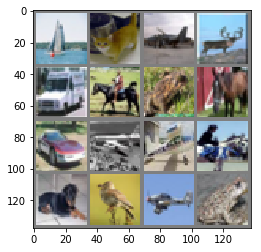

In [6]:
dataiter = iter(trainloader)
i, l = dataiter.next()
g = torchvision.utils.make_grid(i, nrow=4)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

print(l)

In [7]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.c1 = nn.Conv2d(3, 16, kernel_size=5)
        self.c2 = nn.Conv2d(16, 32, kernel_size=3)
        self.c3 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.fc1 = nn.Linear(64 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.dropout1 = nn.Dropout()
        self.dropout2 = nn.Dropout()
    
    def forward(self, x):
        
        x = F.relu(self.c1(x))
        x = self.bn1(F.max_pool2d(x, kernel_size=2))
        
        x = F.relu(self.c2(x))
        x = self.bn2(F.max_pool2d(x, kernel_size=2))
        
        x = F.relu(self.c3(x))
        x = self.bn3(F.max_pool2d(x, kernel_size=2))
        
        x = x.view(-1, 64 * 2 * 2)
        
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x
    

In [8]:
cnn = CNN()
cnn.to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = 1e-2, momentum=0.9)

lr_update = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_update)

In [9]:
## print number of parameters in network:
pcount = 0
for p in cnn.parameters():
    pcount += p.numel()
    
print("Total trainable parameter count: {}".format(pcount))

Total trainable parameter count: 107466


In [10]:
%%time
print_step = len(trainset) // (trainloader.batch_size * 4)
cnn.train(True)
for e in range(80):
    running_loss = 0.
    scheduler.step(epoch=e)
    
    for i, batch in enumerate(trainloader, 1):
        x, label = batch
        x, label = x.to(device), label.to(device)
        
        optimizer.zero_grad()
        out = cnn.forward(x)
        loss = loss_fun(out, label)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_step == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i, running_loss / print_step))
            running_loss = 0.
            
cnn.train(False)

[1,   781] loss: 1.912
[1,  1562] loss: 1.676
[1,  2343] loss: 1.585
[1,  3124] loss: 1.491
[2,   781] loss: 1.410
[2,  1562] loss: 1.389
[2,  2343] loss: 1.341
[2,  3124] loss: 1.329
[3,   781] loss: 1.265
[3,  1562] loss: 1.255
[3,  2343] loss: 1.247
[3,  3124] loss: 1.211
[4,   781] loss: 1.155
[4,  1562] loss: 1.165
[4,  2343] loss: 1.162
[4,  3124] loss: 1.137
[5,   781] loss: 1.102
[5,  1562] loss: 1.108
[5,  2343] loss: 1.090
[5,  3124] loss: 1.077
[6,   781] loss: 1.030
[6,  1562] loss: 1.065
[6,  2343] loss: 1.048
[6,  3124] loss: 1.048
[7,   781] loss: 0.985
[7,  1562] loss: 1.001
[7,  2343] loss: 0.998
[7,  3124] loss: 1.008
[8,   781] loss: 0.959
[8,  1562] loss: 0.957
[8,  2343] loss: 0.960
[8,  3124] loss: 0.964
[9,   781] loss: 0.923
[9,  1562] loss: 0.932
[9,  2343] loss: 0.912
[9,  3124] loss: 0.936
[10,   781] loss: 0.878
[10,  1562] loss: 0.892
[10,  2343] loss: 0.908
[10,  3124] loss: 0.900
[11,   781] loss: 0.851
[11,  1562] loss: 0.868
[11,  2343] loss: 0.894
[11,

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

GroundTruth:      3     8     8     0     6     6     1     6


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2ba7caac2ba8>>
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/yardima/.pye

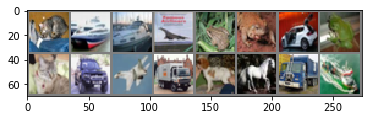

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(8)))

In [13]:
y = cnn.forward(images.to(device)).cpu().data.numpy()
c = np.argmax(y, axis=1)
c

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2ba7d3fc39b0>>
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/yardima/.pye

GroundTruth:      5     7     8     6     7     0     4     9


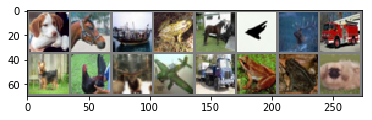

In [14]:
dataiter = iter(testloader)
dataiter.next()
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(8)))

In [15]:
y = cnn.forward(images.to(device)).cpu().data.numpy()
c = np.argmax(y, axis=1)
c

array([5, 7, 8, 6, 7, 2, 4, 9, 4, 2, 4, 0, 9, 6, 6, 5])

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}%'.format(
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74.72%
